<a href="https://colab.research.google.com/github/diegohugo570/backup-codigos/blob/main/04_Routers_%26_Arquitetura_de_Agentes_%7C_Curso_de_LangGraph_DascIA_Academy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Routers & Arquitetura de Agentes

Neste notebook vamos unir dois conceitos fundamentais:

1. **Router** — Fluxo com desvio condicional baseado na resposta do modelo (com ou sem uso de ferramenta).
2. **Agente com Loop** — Um modelo que chama ferramentas, recebe a resposta e decide se continua ou termina (baseado em [ReAct](https://arxiv.org/pdf/2210.03629)).

---

## Parte 1 — Router com Ferramenta

Aqui criamos um grafo com dois nós principais:
- `tool_calling_llm`: executa um modelo com ferramentas vinculadas
- `tools`: nó que executa a ferramenta se for chamada

A transição entre eles é feita com uma **aresta condicional**, usando `tools_condition`.

In [ ]:
!pip install -qU langchain-openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 11.3 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata

# Configuração de ambiente
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_env("OPENAI_API_KEY")

In [ ]:
# Definição do Estado

from typing_extensions import TypedDict, Annotated
from typing import List
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

In [ ]:
from langchain_core.tools import tool
# Definição das ferramentas

@tool
def multiplica(a: float, b: float) -> float:
  """Retorna a multiplicação de dois números inteiros"""
  return a * b

@tool
def soma(a: float, b: float) -> float:
  """Retorna a multiplicação de dois números inteiros"""
  return a + b

tools = [multiplica, soma]

In [ ]:
from langchain_openai import ChatOpenAI

# Definição do modelo LLM
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Definição dos nós
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
from langgraph.graph import END
from typing import Literal

# Criando o nó de execução da ferramenta
tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: MessagesState) -> MessagesState:
  result = []
  for tool_call in state["messages"][-1].tool_calls:
      tool = tools_by_name[tool_call["name"]]
      result.append(tool.invoke(tool_call))
  return {"messages": result}

In [ ]:
# Criando a aresta condicional
def tool_condition(state: MessagesState) -> Literal["tools", END]:
  if state["messages"][-1].tool_calls:
    return "tools"
  return END

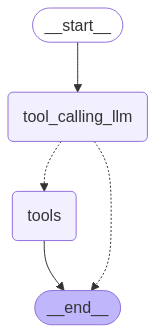

In [ ]:
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

# Construção do grafo
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", tool_node)

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              # Se a última mensagem (resultado) do assistente for uma chamada de função, tools_condition retorna para o nó de ferramentas
                              # Se a última mensagem (resultado) do assistente não for uma chamada de função, então tools_condition retorna para o final
                              tool_condition)
builder.add_edge("tools", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

# Execução
mensagens = [HumanMessage(content="Olá, quanto é 5 + 5?")]
resposta = graph.invoke({"messages": mensagens})
for m in resposta['messages']:
    m.pretty_print()

================================ Human Message =================================

Olá, quanto é 5 + 5?
================================== Ai Message ==================================
Tool Calls:
  soma (call_5MiNCVktDsRguvXYvZPWWCtx)
 Call ID: call_5MiNCVktDsRguvXYvZPWWCtx
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: soma

10.0


## Parte 2 — Criando um Agente com Loop (ReAct)

A ideia agora é estender o comportamento do Router para um ciclo completo de agente:

- O modelo decide usar uma ferramenta
- A ferramenta retorna um resultado
- O resultado volta para o modelo
- O modelo decide novamente: encerrar ou continuar

Esse comportamento segue o padrão **ReAct** (Reason + Act + Observe).

Vamos usar as ferramentas: `add`, `multiply`.

In [ ]:
# Mensagem inicial
from langchain_core.messages import SystemMessage
sys_msg = SystemMessage(content="Você é um assistente útil responsável por realizar cálculos matemáticos.")

# Nó principal (LLM)
def assistant_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

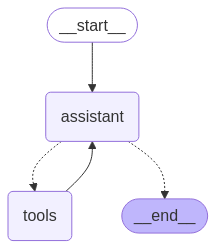

In [ ]:
# Construção do grafo com loop
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Execução com raciocínio em etapas
entrada = [HumanMessage(content="Some 3 com 4. Multiplique o resultado por 2. Divida o resultado por 5")]
resposta = react_graph.invoke({"messages": entrada})
for m in resposta['messages']:
    m.pretty_print()

================================ Human Message =================================

Some 3 com 4. Multiplique o resultado por 2. Divida o resultado por 5
================================== Ai Message ==================================
Tool Calls:
  soma (call_ZnkURgeYMNRhtCA0zX0ApfGP)
 Call ID: call_ZnkURgeYMNRhtCA0zX0ApfGP
  Args:
    a: 3
    b: 4
  multiplica (call_8KD9eBQbD5RRtqNDSPimLL8b)
 Call ID: call_8KD9eBQbD5RRtqNDSPimLL8b
  Args:
    a: 2
    b: 0
================================= Tool Message =================================
Name: soma

7.0
================================= Tool Message =================================
Name: multiplica

0.0
================================== Ai Message ==================================
Tool Calls:
  multiplica (call_je36tyTwW1nLMgfAsFL8sduK)
 Call ID: call_je36tyTwW1nLMgfAsFL8sduK
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiplica

14.0
===============================

### Adicionando Memória com Checkpointer

LangGraph oferece o `MemorySaver`, que salva o estado automaticamente a cada passo do grafo. Basta compilar com o `checkpointer`.

In [ ]:
# Criando um grafo com memória
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

In [ ]:
# Criando um identificador de sessão (thread)
config = {"configurable": {"thread_id": "1"}}

# Primeira execução
mensagens = [HumanMessage(content="Some 3 com 4.")]
resposta = react_graph.invoke({"messages": mensagens}, config)
for m in resposta['messages']:
  m.pretty_print()

================================ Human Message =================================

Some 3 com 4.
================================== Ai Message ==================================
Tool Calls:
  soma (call_ctEWfyBihCjNsP1pdsSRa2pJ)
 Call ID: call_ctEWfyBihCjNsP1pdsSRa2pJ
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: soma

7.0
================================== Ai Message ==================================

A soma de 3 com 4 é 7.


In [ ]:
# Segunda execução, mesmo contexto
mensagens = [HumanMessage(content="Multiplique isso por 2.")]
resposta = react_graph.invoke({"messages": mensagens}, config)
for m in resposta['messages']:
  m.pretty_print()

================================ Human Message =================================

Some 3 com 4.
================================== Ai Message ==================================
Tool Calls:
  soma (call_ctEWfyBihCjNsP1pdsSRa2pJ)
 Call ID: call_ctEWfyBihCjNsP1pdsSRa2pJ
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: soma

7.0
================================== Ai Message ==================================

A soma de 3 com 4 é 7.
================================ Human Message =================================

Multiplique isso por 2.
================================== Ai Message ==================================
Tool Calls:
  multiplica (call_OivhquvcPzcDNSeQuE5ODGti)
 Call ID: call_OivhquvcPzcDNSeQuE5ODGti
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiplica

14.0
================================== Ai Message ==================================

Multipli